# Identifying Network Protocols using Neural Networks for IoT Applications
Emin Arslan

### Proposal
I will build a new neural network. The model will identify different network protocols (like Bluetooth, ZigBee, WiFi, or just noise), from a given signal. This is becoming increasingly important in IoT (internet of things) applications, as low-power protocols like Bluetooth and Zigbee are easily overpowered by high-power protocols like WiFi, leading to a loss in data throughput. Many IoT devices are also starting to get edge AI accelerators, making neural networks a good possible alternative to traditional signal processing techniques. I plan on generating my own data, but I might look into using data from other sources as well. Here are some relevant resources I have found for datasets and data generation: https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.htmlLinks and https://www.deepsig.ai/datasetsLinks.  One of my experiments will be trying out different network architectures (comparing CNNs vs RNNs and maybe even combinations of both, different number of layers). Most of the papers that deal with similar problems seem to use CNNs, so I am curious about how RNNs will work for this problem. I will compare their accuracy, and also their speed since the model has to be fast to be useful. My second experiment will be using the different regularization techniques we learned in class and measuring how well they help the model generalize from the training data. I will work on this project by myself.

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

### Data Processing/Generation

In [3]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

classes = {"BLE": 0, "Zigbee": 1, "Noise": 2}

class SignalData(Dataset):
    def __init__(self, csv_file_path, transform=None):
        df = pd.read_csv(csv_file_path, header=None)
        data = np.asarray(df.iloc[:, 5:-1], dtype=np.float32)
        samples = len(data[0])
        self.data = data.reshape(-1, 2, samples)
        self.labels = np.asarray(df.iloc[range(0, len(df), 2), 4])
        # BLE vs Zigbee sensor mode
        self.modes = np.asarray(df.iloc[range(0, len(df), 2), 2], dtype=np.int8)
        # signal to noise ratios
        self.SNRs = np.asarray(df.iloc[range(0, len(df), 2), 1])
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        result = self.data[idx]
        label = classes[self.labels[idx].strip()]
        mode = self.modes[idx]
        SNR = self.SNRs[idx]
        
        if self.transform:
            result = self.transform(result)
            
        return result, label, SNR, mode
    
dataset = SignalData("./data/data_iq.csv")
ntotal = len(dataset)
print(ntotal)

48000


label=1
snr=-10
mode=1


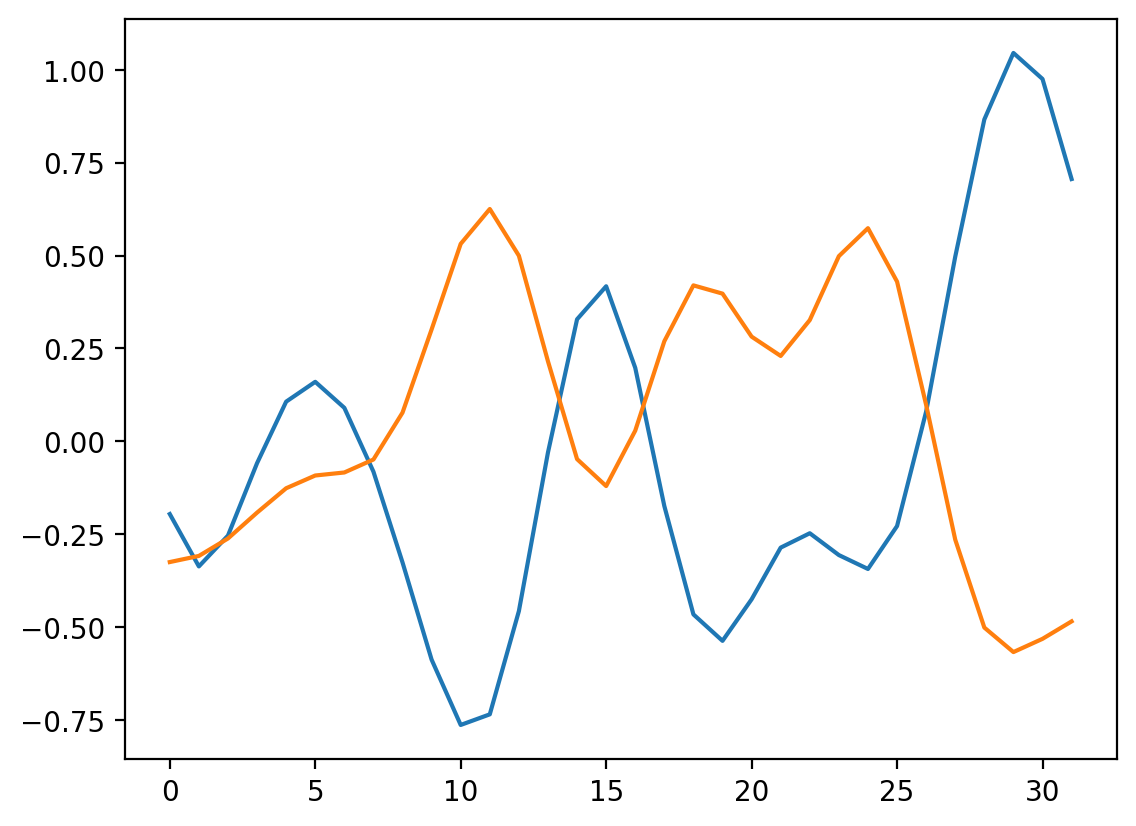

In [4]:
signal, label, snr, mode = dataset[1]
print(f"{label=}")
print(f"{snr=}")
print(f"{mode=}")
plt.plot(signal[0])
plt.plot(signal[1])

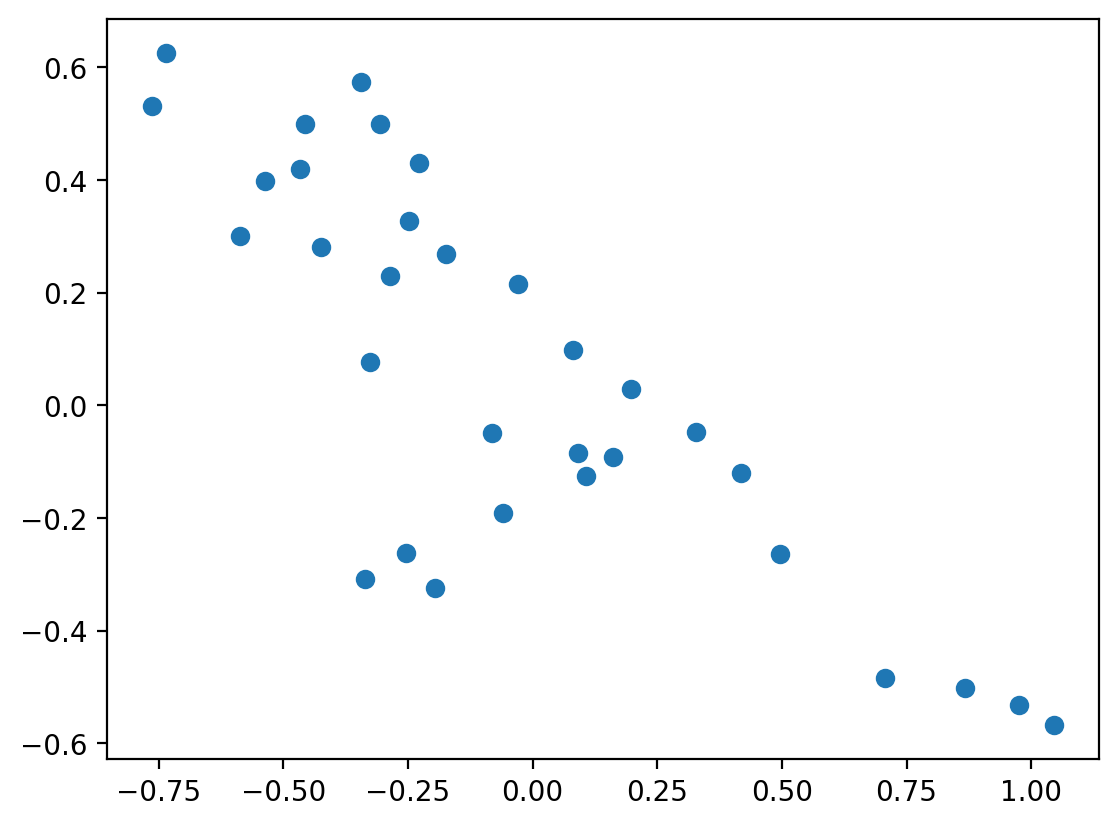

In [4]:
signal, label, snr, _ = dataset[1]
plt.scatter(signal[0], signal[1])

In [5]:
ntrain = int(0.7 * ntotal)
ntest = int(0.2 * ntotal)
nval = ntotal - ntrain - ntest

train_idx = np.random.choice(range(ntotal), size=ntrain, replace=False)
test_idx = np.random.choice(list(set(range(ntotal)) - set(train_idx)), size=ntest, replace=False)
val_idx = list(set(range(ntotal)) - set(train_idx) - set(test_idx))

# sanity checks
assert len(val_idx) == nval
assert len(set(train_idx) & set(test_idx)) == 0
assert len(set(train_idx) & set(val_idx)) == 0
assert len(set(test_idx) & set(val_idx)) == 0

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [7]:
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

### Defining & Training the Model

In [7]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### CNN

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.layers = nn.Sequential(
            # convolve over i, q individually first
            nn.Conv2d(1, 16, (1, 4)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            # convolve over both i, q
            nn.Conv2d(16, 32, (2, 4)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, len(classes))
        )
        
    def forward(self, x):
        # add dimension for channel
        return self.layers(x.unsqueeze(dim=1))

In [9]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = CNNModel()
    outputs = model(inputs)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 3])


/home/arsem/Developer/CS-342-Neural-Networks/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
cnn_model = CNNModel()
cnn_model.to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

In [8]:
def train_cnn(model, train_loader, val_loader, criterion, optimizer, nepoch=5):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels, _, _ in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels, _, _ in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_cnn(model, test_loader):
    SNR_vals = list(range(-10, 30, 5))
    SNR2idx = {s:i for i, s in enumerate(SNR_vals)}
    correct = np.zeros(len(SNR2idx))
    total = np.zeros(len(SNR2idx))
    with torch.no_grad():
        for inputs, labels, SNR, _ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1)
            for pred, targ, snr in zip(predicted, labels, SNR):
                correct[SNR2idx[snr.item()]] += (pred == targ).item()
                total[SNR2idx[snr.item()]] += 1

    all_acc = (100 * sum(correct) / sum(total))
    print('Test accuracy: %0.3f' % (all_acc))
    print({val:acc for val, acc in zip(SNR_vals, correct/total)})
    plt.plot(SNR_vals, correct/total)
    plt.xlabel("SNR")
    plt.ylabel("accuracy")

#### RNN

In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=True):
        super(RNNModel, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fcn = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, len(classes))
        )
        
    def forward(self, x, h):
        out, hn = self.rnn(x.permute(0, 2, 1), h)
        out = self.fcn(out)
        return out, hn

In [13]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = RNNModel(2, 512, 3, True)
    h = torch.zeros((3*2, batch_size, 512))
    outputs, h = model(inputs, h)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 32, 3])


In [14]:
hidden_size = 512
num_layers = 3
rnn_model = RNNModel(2, hidden_size, num_layers, True)
rnn_model.to(device)
rnn_criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

In [9]:
def train_rnn(model, train_loader, val_loader, criterion, optimizer, nepoch=5, random_seq_lens=False):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
            for inputs, labels, _, _ in train_loader:
                optimizer.zero_grad()
                if random_seq_lens:
                    r_idx = random.randint(1, len(inputs)-1)
                    inputs = np.delete(inputs, np.s_[r_idx:], 2)
                # duplicate labels for each sample (creates new dimension to repeat elements across)
                labels = np.repeat(labels[:, np.newaxis], inputs.shape[-1], axis=1)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, h = model(inputs, h.detach())
                loss = criterion(outputs.permute(0, 2, 1), labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            
            with torch.no_grad():
                total_loss = 0
                count = 0
                h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
                for inputs, labels, _, _ in val_loader:
                    labels = np.repeat(labels[:, np.newaxis], inputs.shape[-1], axis=1)
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs, h = model(inputs, h.detach())                    
                    loss = criterion(outputs.permute(0, 2, 1), labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_rnn(model, test_loader, seq_len):
    SNR_vals = list(range(-10, 30, 5))
    SNR2idx = {s:i for i, s in enumerate(SNR_vals)}
    
    correct = np.zeros(len(SNR2idx))
    total = np.zeros(len(SNR2idx))
    h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
    
    with torch.no_grad():
        for inputs, labels, SNRs, _ in test_loader:
            # keep only seq_len samples
            inputs = np.delete(inputs, np.s_[seq_len:], 2)
            labels = np.repeat(labels[:, np.newaxis], inputs.shape[-1], axis=1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, h = model(inputs, h.detach())
            predicted = outputs.argmax(dim=2)
            
            for pred, targ, snr in zip(predicted, labels, SNRs):
                correct[SNR2idx[snr.item()]] += (pred == targ).sum().item()
                total[SNR2idx[snr.item()]] += len(pred)
                
    all_acc = (100 * sum(correct) / sum(total))
    print('Test accuracy: %0.3f' % (all_acc))
    print({val:acc for val, acc in zip(SNR_vals, correct/total)})
    plt.plot(SNR_vals, correct/total)
    plt.xlabel("SNR")
    plt.ylabel("accuracy")

### Training & Evaluating the Models

#### CNN

In [16]:
train_cnn(cnn_model, train_loader, val_loader, cnn_criterion, cnn_optimizer, nepoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.67966
   Val loss: 0.58738

EPOCH 1
 Train loss: 0.57385
   Val loss: 0.55627

EPOCH 2
 Train loss: 0.55928
   Val loss: 0.55065

EPOCH 3
 Train loss: 0.55003
   Val loss: 0.54766

EPOCH 4
 Train loss: 0.54459
   Val loss: 0.54298



Test accuracy: 76.771
{-10: 0.36468646864686466, -5: 0.4035683942225998, 0: 0.608874281018899, 5: 0.8856655290102389, 10: 0.9686174724342663, 15: 0.9686727122835944, 20: 0.9680940386230059, 25: 0.9717514124293786}


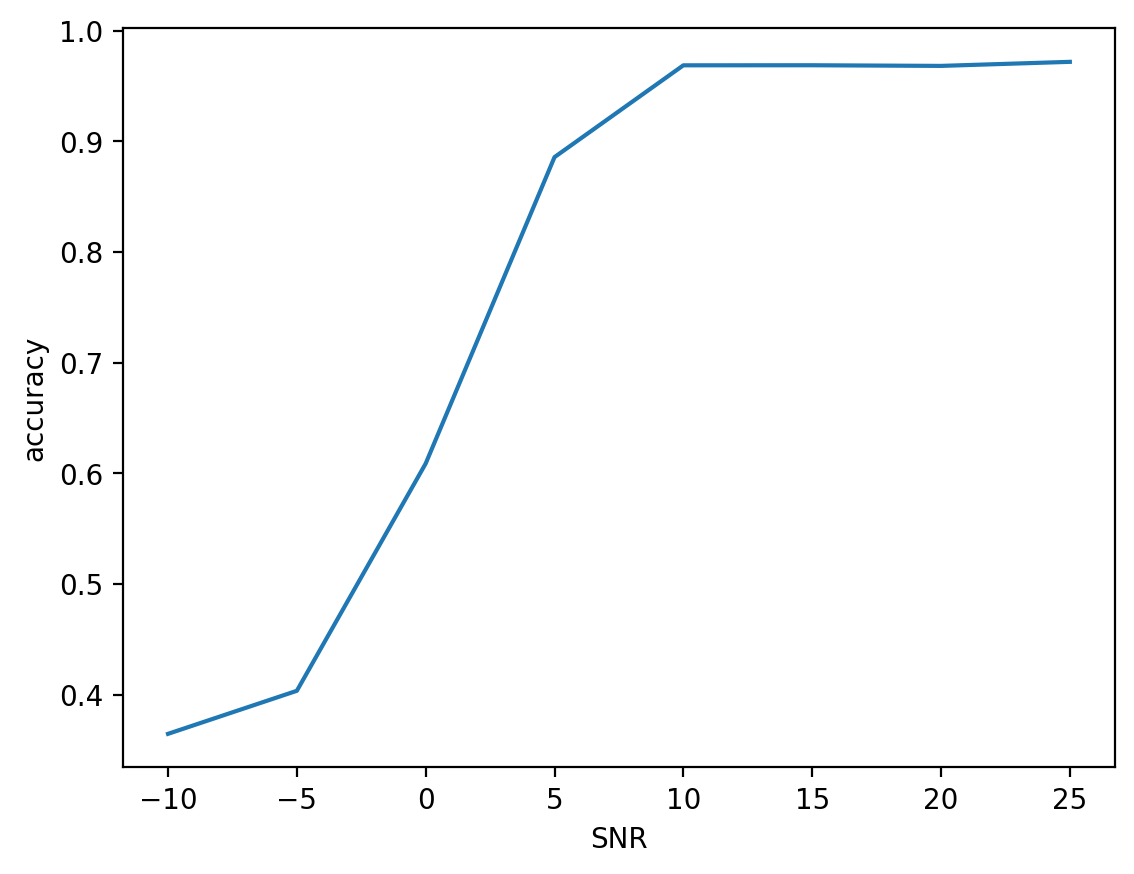

In [17]:
cnn_model.eval()
test_cnn(cnn_model, test_loader)

In [18]:
print(f"{count_params(cnn_model):,}")

695,411


In [20]:
inputs, _, _, _ = next(iter(test_loader))
inputs = inputs.to(device)
%time _ = cnn_model(inputs)

CPU times: user 368 µs, sys: 118 µs, total: 486 µs
Wall time: 493 µs


#### RNN

In [21]:
train_rnn(rnn_model, train_loader, val_loader, rnn_criterion, rnn_optimizer, nepoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.67865
   Val loss: 0.61706

EPOCH 1
 Train loss: 0.60692
   Val loss: 0.58719

EPOCH 2
 Train loss: 0.58092
   Val loss: 0.55495

EPOCH 3
 Train loss: 0.55792
   Val loss: 0.56168

EPOCH 4
 Train loss: 0.54739
   Val loss: 0.54755



Test accuracy: 76.851
{-10: 0.3533931518151815, -5: 0.3978069243840272, 0: 0.6173223089564502, 5: 0.9124626706484642, 10: 0.9758269720101781, 15: 0.9614591920857378, 20: 0.9631612090680101, 25: 0.9657990314769975}
Test accuracy: 72.182
{-10: 0.33859323432343236, -5: 0.3659197111299915, 0: 0.48921528348397697, 5: 0.7927154436860068, 10: 0.9320928753180662, 15: 0.9459501236603463, 20: 0.9587531486146096, 25: 0.9489003228410008}


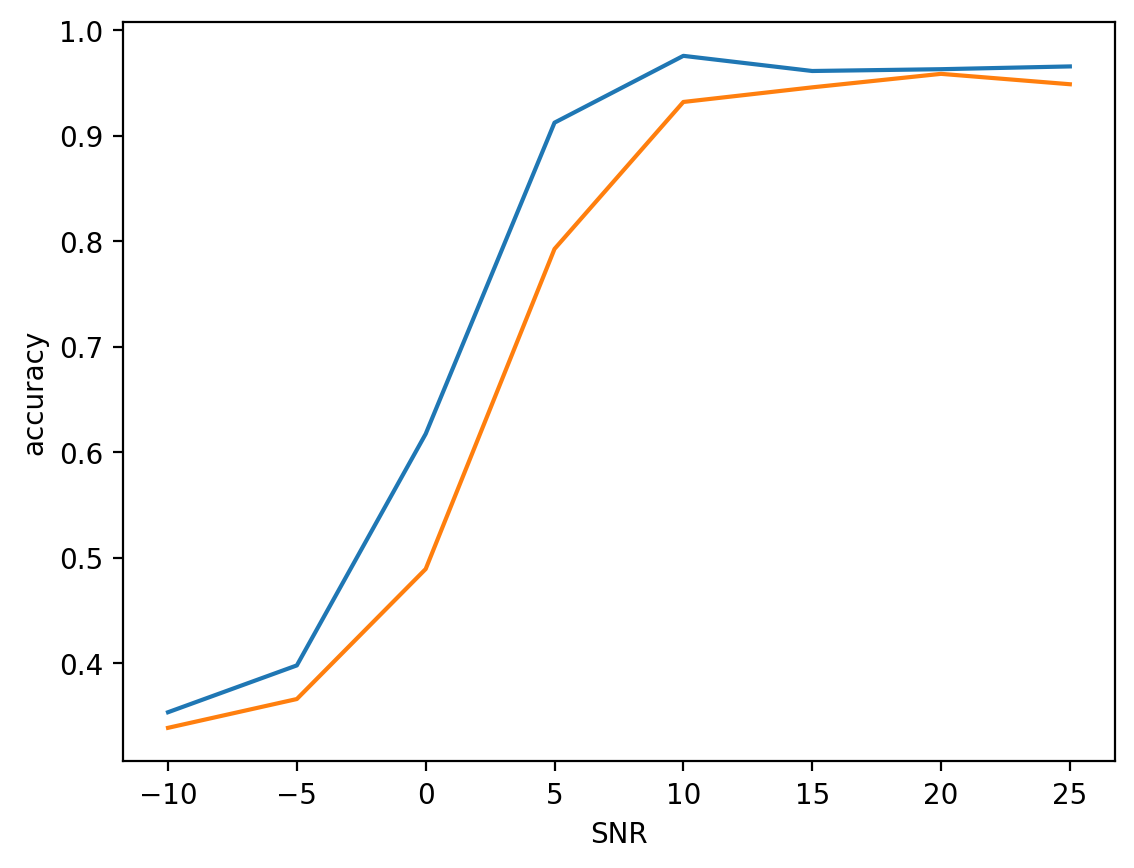

In [23]:
rnn_model.eval()
test_rnn(rnn_model, test_loader, 32)
test_rnn(rnn_model, test_loader, 16)

In [24]:
print(f"{count_params(rnn_model):,}")

12,610,563


In [25]:
inputs, _, _, _ = next(iter(test_loader))
inputs = inputs.to(device)
h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
%time _ = rnn_model(inputs, h)

CPU times: user 4.78 ms, sys: 395 µs, total: 5.18 ms
Wall time: 1.75 ms


### Experiment 1: Experimenting with different network architectures

#### FCN

Fixes the disadvantage of fixed input size in normal CNNs

In [86]:
class FCNModel(nn.Module):
    def __init__(self):
        super(FCNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 4), padding="same"),
            nn.ReLU(),
            nn.Conv2d(16, 64, (1, 4), padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 128, (2, 4)),
            nn.ReLU()
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, len(classes), kernel_size=1),
        )
        
    def forward(self, x):
        # add dimension for channel
        out = self.conv(x.unsqueeze(dim=1))
        out = self.fc(out)
        #out, _ = torch.max(out, -1)
        #out = torch.mean(out, -1)
        out = torch.squeeze(out)
        out = self.avg_pool(out)
        out = torch.squeeze(out)
        return out

In [87]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = FCNModel()
    outputs = model(inputs)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 3])


In [88]:
fcn_model = FCNModel()
fcn_model.to(device)
fcn_criterion = nn.CrossEntropyLoss()
fcn_optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-4)

In [89]:
def train_fcn(model, train_loader, val_loader, criterion, optimizer, nepoch=5, random_seq_lens=0):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels, _, _ in train_loader:
                if random_seq_lens:
                    r_idx = random.randint(random_seq_lens, len(inputs)-1)
                    inputs = np.delete(inputs, np.s_[r_idx:], 2)
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels, _, _ in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_fcn(model, test_loader, seq_len):
    SNR_vals = list(range(-10, 30, 5))
    SNR2idx = {s:i for i, s in enumerate(SNR_vals)}
    correct = np.zeros(len(SNR2idx))
    total = np.zeros(len(SNR2idx))
    with torch.no_grad():
        for inputs, labels, SNR, _ in test_loader:
            # keep only seq_len samples
            inputs = np.delete(inputs, np.s_[seq_len:], 2)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1)
            for pred, targ, snr in zip(predicted, labels, SNR):
                correct[SNR2idx[snr.item()]] += (pred == targ).item()
                total[SNR2idx[snr.item()]] += 1

    all_acc = (100 * sum(correct) / sum(total))
    print('Test accuracy: %0.3f' % (all_acc))
    print({val:acc for val, acc in zip(SNR_vals, correct/total)})
    plt.plot(SNR_vals, correct/total)
    plt.xlabel("SNR")
    plt.ylabel("accuracy")

In [90]:
train_fcn(fcn_model, train_loader, val_loader, fcn_criterion, fcn_optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.76576
   Val loss: 0.61435

EPOCH 1
 Train loss: 0.60551
   Val loss: 0.59024

EPOCH 2
 Train loss: 0.58762
   Val loss: 0.57085

EPOCH 3
 Train loss: 0.57848
   Val loss: 0.57460

EPOCH 4
 Train loss: 0.57031
   Val loss: 0.55390

EPOCH 5
 Train loss: 0.56426
   Val loss: 0.54777

EPOCH 6
 Train loss: 0.55896
   Val loss: 0.54572

EPOCH 7
 Train loss: 0.55421
   Val loss: 0.54043

EPOCH 8
 Train loss: 0.55150
   Val loss: 0.53537

EPOCH 9
 Train loss: 0.54913
   Val loss: 0.53642



Test accuracy: 76.385
{-10: 0.3577981651376147, -5: 0.39600665557404324, 0: 0.6311146752205292, 5: 0.8963466440101954, 10: 0.9638655462184874, 15: 0.955, 20: 0.9601949634443542, 25: 0.962738301559792}
Test accuracy: 71.583
{-10: 0.36363636363636365, -5: 0.4043261231281198, 0: 0.5637530072173216, 5: 0.7977909940526763, 10: 0.8949579831932774, 15: 0.9066666666666666, 20: 0.8968318440292445, 25: 0.9107452339688041}
Test accuracy: 63.323
{-10: 0.3561301084236864, -5: 0.3685524126455907, 0: 0.5012028869286287, 5: 0.6771452846219201, 10: 0.7781512605042017, 15: 0.8008333333333333, 20: 0.8066612510154346, 25: 0.7859618717504333}


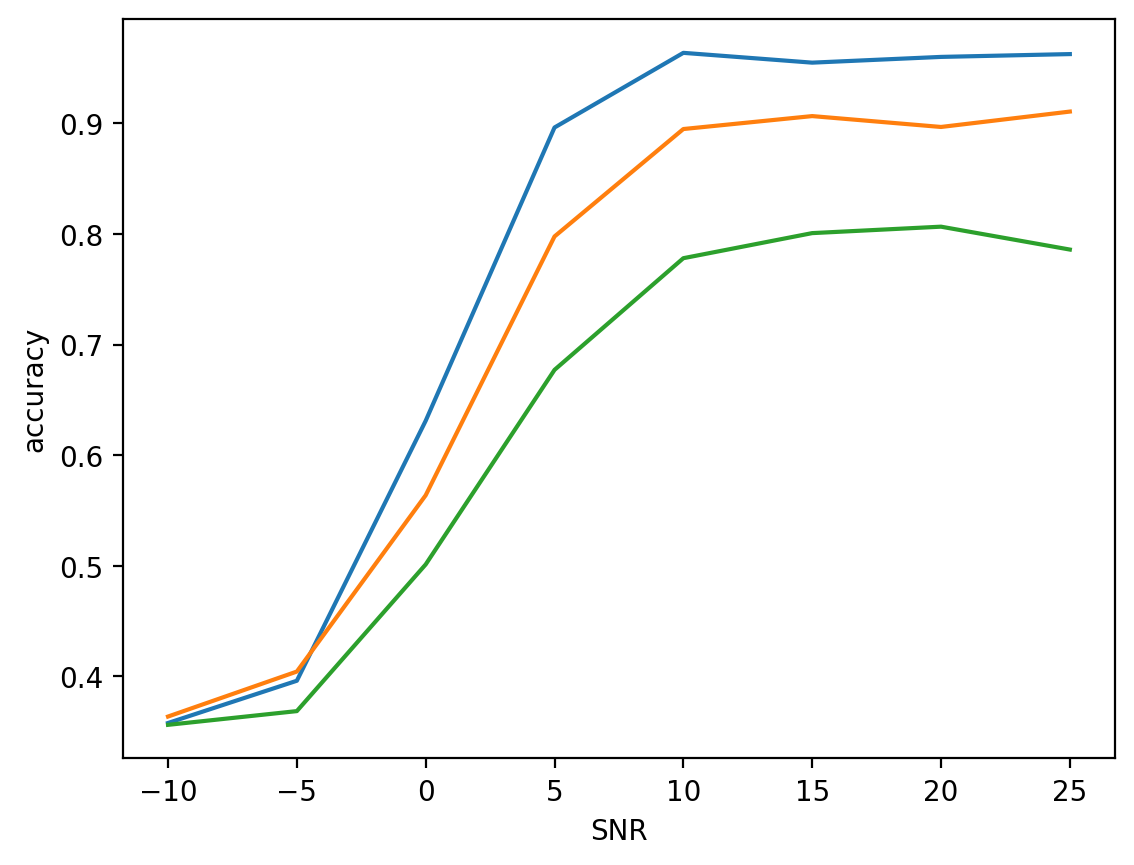

In [91]:
fcn_model.eval()
test_fcn(fcn_model, test_loader, 32)
test_fcn(fcn_model, test_loader, 16)
test_fcn(fcn_model, test_loader, 8)

In [35]:
cnn_model.eval()
try:
    test_fcn(cnn_model, test_loader, 16)
except RuntimeError:
    print("CNNs can't handle arbitrary sample length")

CNNs can't handle arbitrary sample length


In [36]:
print(f"{count_params(fcn_model):,}")

8,819


In [37]:
inputs, _, _, _ = next(iter(test_loader))
inputs = inputs.to(device)
%time _ = cnn_model(inputs)

CPU times: user 456 µs, sys: 37 µs, total: 493 µs
Wall time: 499 µs


#### RNN-FCN

In [40]:
class RNN_FCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, conv_out_size, bidirectional=True):
        super(RNN_FCNModel, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, (1, 3)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Conv2d(32, 128, (2, 3)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Conv2d(128, conv_out_size, kernel_size=1),
            nn.ReLU()
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fcn = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1) + conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, len(classes))
        )
        
    def forward(self, x, h):
        # rnn
        rnn_out, hn = self.rnn(x.permute(0, 2, 1), h)
        # only use last rnn output
        last_rnn_out = rnn_out[:, -1]
        # fcn
        cnn_out = self.cnn(x.unsqueeze(dim=1))
        cnn_out = torch.squeeze(cnn_out)
        cnn_out = self.avg_pool(cnn_out)
        cnn_out = torch.squeeze(cnn_out)
        # combine
        out = torch.concat([last_rnn_out, cnn_out], dim=1)
        out = self.fcn(out)
        return out, hn

In [41]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = RNN_FCNModel(input_size=2, hidden_size=512, num_layers=3, conv_out_size=256, bidirectional=True)
    h = torch.zeros((3*2, batch_size, 512))
    outputs, h = model(inputs, h)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 3])


In [42]:
hidden_size = 512
num_layers = 3
conv_out_size = 256
rnn_fcn_model = RNN_FCNModel(2, hidden_size, num_layers, conv_out_size, True)
rnn_fcn_model.to(device)
rnn_fcn_criterion = nn.CrossEntropyLoss()
rnn_fcn_optimizer = torch.optim.Adam(rnn_fcn_model.parameters(), lr=1e-3)

In [11]:
def train_rnn_fcn(model, train_loader, val_loader, criterion, optimizer, nepoch=5):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
            for inputs, labels, _, _ in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs, h = model(inputs, h.detach())
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
                for inputs, labels, _, _ in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs, h = model(inputs, h.detach())
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_rnn_fcn(model, test_loader, seq_len):
    SNR_vals = list(range(-10, 30, 5))
    SNR2idx = {s:i for i, s in enumerate(SNR_vals)}
    correct = np.zeros(len(SNR2idx))
    total = np.zeros(len(SNR2idx))
    h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
    with torch.no_grad():
        for inputs, labels, SNR, _ in test_loader:
            # keep only seq_len samples
            inputs = np.delete(inputs, np.s_[seq_len:], 2)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, h = model(inputs, h.detach())
            predicted = outputs.argmax(dim=1)
            for pred, targ, snr in zip(predicted, labels, SNR):
                correct[SNR2idx[snr.item()]] += (pred == targ).item()
                total[SNR2idx[snr.item()]] += 1

    all_acc = (100 * sum(correct) / sum(total))
    print('Test accuracy: %0.3f' % (all_acc))
    print({val:acc for val, acc in zip(SNR_vals, correct/total)})
    plt.plot(SNR_vals, correct/total)
    plt.xlabel("SNR")
    plt.ylabel("accuracy")

In [44]:
train_rnn_fcn(rnn_fcn_model, train_loader, val_loader, rnn_fcn_criterion, rnn_fcn_optimizer, nepoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.63407
   Val loss: 0.55318

EPOCH 1
 Train loss: 0.56453
   Val loss: 0.54814

EPOCH 2
 Train loss: 0.55512
   Val loss: 0.54457



Test accuracy: 76.656
{-10: 0.367986798679868, -5: 0.4010195412064571, 0: 0.6203779786359901, 5: 0.8924914675767918, 10: 0.9669211195928753, 15: 0.9612530915086562, 20: 0.9596977329974811, 25: 0.9612590799031477}
Test accuracy: 69.885
{-10: 0.3547854785478548, -5: 0.3806287170773152, 0: 0.5283483976992605, 5: 0.7610921501706485, 10: 0.8854961832061069, 15: 0.8953009068425392, 20: 0.892527287993283, 25: 0.8902340597255851}


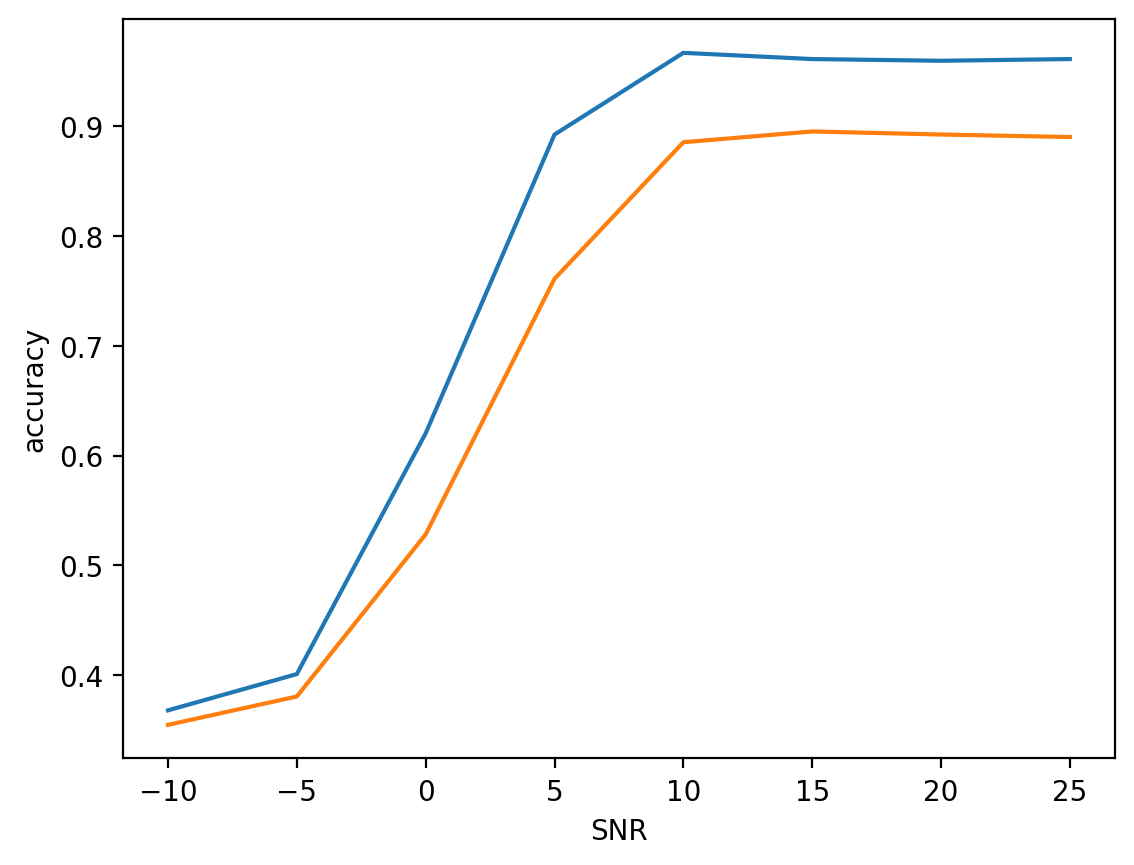

In [45]:
rnn_fcn_model.eval()
test_rnn_fcn(rnn_fcn_model, test_loader, 32)
test_rnn_fcn(rnn_fcn_model, test_loader, 16)

In [46]:
print(f"{count_params(rnn_fcn_model):,}")

12,930,563


In [47]:
inputs, _, _, _ = next(iter(test_loader))
inputs = inputs.to(device)
h = torch.zeros((num_layers*2, batch_size, hidden_size)).to(device)
%time _ = rnn_fcn_model(inputs, h)

CPU times: user 5.48 ms, sys: 343 µs, total: 5.82 ms
Wall time: 1.95 ms


### Experiment 2: Applying regularization techniques to improve generalization and performance

#### CNN

In [48]:
class RegCNNModel(nn.Module):
    def __init__(self):
        super(RegCNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 3)),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.BatchNorm2d(16), # batch norm after dropout provides improvements in lower SNR accuracy
            nn.MaxPool2d((1, 2)),
            nn.Conv2d(16, 32, (2, 3)),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((1, 2))
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, len(classes))
        )
        
    def forward(self, x):
        # add dimension for channel
        out = self.conv(x.unsqueeze(dim=1))
        out = self.flatten(out)
        out = self.fc(out)
        return out

In [49]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = RegCNNModel()
    outputs = model(inputs)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 3])


In [50]:
cnn_model = RegCNNModel()
cnn_model.to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [51]:
train_cnn(cnn_model, train_loader, val_loader, cnn_criterion, cnn_optimizer, nepoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.76663
   Val loss: 0.67708

EPOCH 1
 Train loss: 0.65345
   Val loss: 0.63784

EPOCH 2
 Train loss: 0.62635
   Val loss: 0.61538

EPOCH 3
 Train loss: 0.61667
   Val loss: 0.60588

EPOCH 4
 Train loss: 0.60685
   Val loss: 0.59887



Test accuracy: 76.406
{-10: 0.35973597359735976, -5: 0.37638062871707734, 0: 0.5645028759244043, 5: 0.8703071672354948, 10: 0.9762510602205259, 15: 0.9876339653751031, 20: 0.9865659109991604, 25: 0.9887005649717514}


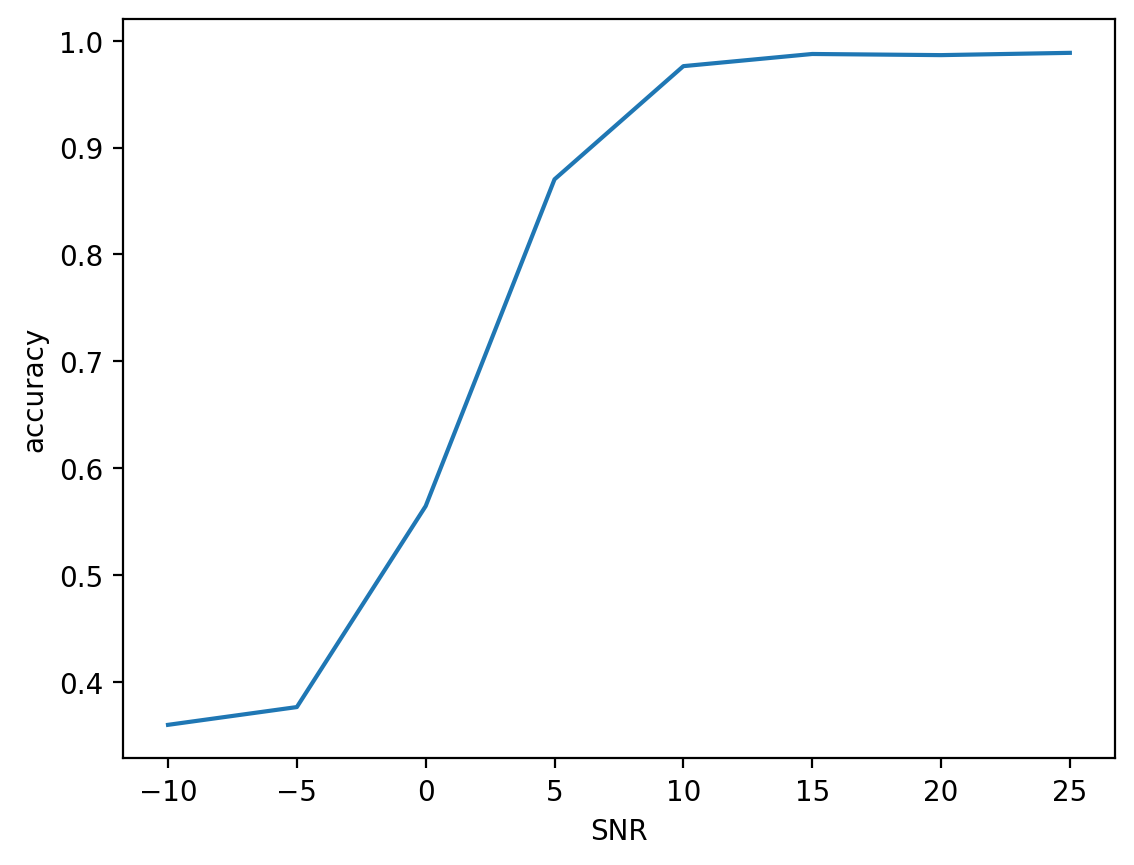

In [52]:
cnn_model.eval()
test_cnn(cnn_model, test_loader)

#### RNN

In [54]:
class RegRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=True):
        super(RegRNNModel, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,
                          dropout=0.2, bidirectional=bidirectional)
        self.fcn = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, len(classes))
        )
        
    def forward(self, x, h):
        out, hn = self.rnn(x.permute(0, 2, 1), h)
        out = self.fcn(out)
        return out, hn

In [55]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = RegRNNModel(2, 512, 3, True)
    h = torch.zeros((3*2, batch_size, 512))
    outputs, h = model(inputs, h)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 32, 3])


In [96]:
hidden_size = 512
num_layers = 3
rnn_model = RegRNNModel(2, hidden_size, num_layers, True)
rnn_model.to(device)
rnn_criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3, weight_decay=1e-5)

In [97]:
train_rnn(rnn_model, train_loader, val_loader, rnn_criterion, rnn_optimizer, nepoch=5, random_seq_lens=False)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.68716
   Val loss: 0.61686

EPOCH 1
 Train loss: 0.61722
   Val loss: 0.59166

EPOCH 2
 Train loss: 0.58618
   Val loss: 0.58114

EPOCH 3
 Train loss: 0.56738
   Val loss: 0.56250

EPOCH 4
 Train loss: 0.55968
   Val loss: 0.56792



Test accuracy: 75.454
{-10: 0.3482879537953795, -5: 0.35819350042480885, 0: 0.508293960558751, 5: 0.8563353242320819, 10: 0.9880460135708228, 15: 0.9940746084089035, 20: 0.9913675482787574, 25: 0.9896842211460856}
Test accuracy: 70.378
{-10: 0.3499381188118812, -5: 0.34770603228547153, 0: 0.44412489728841414, 5: 0.6758745733788396, 10: 0.9212786259541985, 15: 0.9618198680956307, 20: 0.9563916876574308, 25: 0.9671610169491526}
Test accuracy: 56.712
{-10: 0.33436468646864687, -5: 0.356839422259983, 0: 0.4003697617091208, 5: 0.47429607508532423, 10: 0.6220313825275657, 15: 0.7465993404781534, 20: 0.8013224181360201, 25: 0.7930790960451978}
Test accuracy: 45.195
{-10: 0.3457095709570957, -5: 0.3525913338997451, 0: 0.3613393590797042, 5: 0.4104095563139932, 10: 0.4510178117048346, 15: 0.5307089859851608, 20: 0.5665407220822838, 25: 0.5922114608555287}


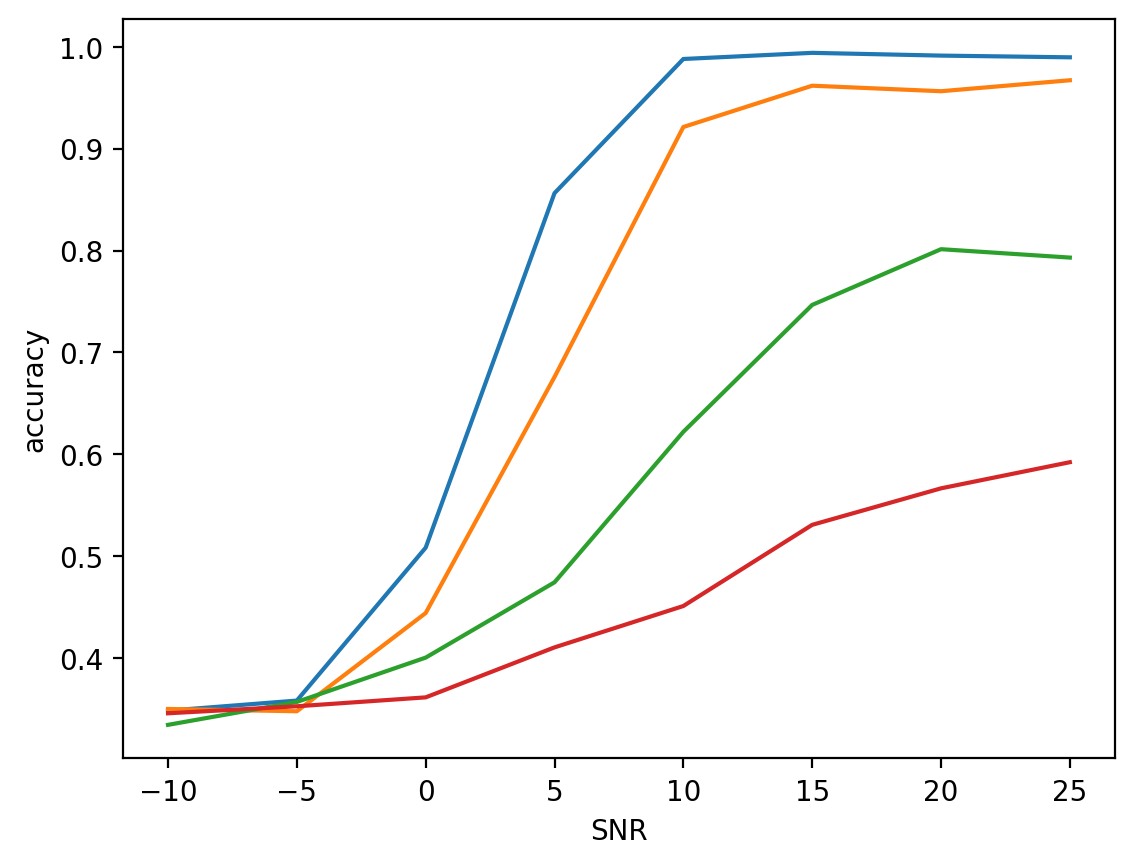

In [98]:
rnn_model.eval()
test_rnn(rnn_model, test_loader, 32)
test_rnn(rnn_model, test_loader, 16)
test_rnn(rnn_model, test_loader, 8)
test_rnn(rnn_model, test_loader, 4)

Training on random sequence lengths instead makes the model better across different number of samples.

In [61]:
train_rnn(rnn_model, train_loader, val_loader, rnn_criterion, rnn_optimizer, nepoch=5, random_seq_lens=True)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.78309
   Val loss: 0.68247

EPOCH 1
 Train loss: 0.68175
   Val loss: 0.60029

EPOCH 2
 Train loss: 0.65510
   Val loss: 0.60779

EPOCH 3
 Train loss: 0.64722
   Val loss: 0.56937

EPOCH 4
 Train loss: 0.64320
   Val loss: 0.55951



Test accuracy: 76.829
{-10: 0.35597153465346537, -5: 0.3821951996601529, 0: 0.5834531635168447, 5: 0.922994880546075, 10: 0.979034139100933, 15: 0.979724855729596, 20: 0.9728694374475231, 25: 0.9694562146892656}
Test accuracy: 73.298
{-10: 0.34808168316831684, -5: 0.3796728971962617, 0: 0.4998972884141331, 5: 0.7913822525597269, 10: 0.9557888040712468, 15: 0.9657357790601814, 20: 0.9638434089000839, 25: 0.9569713478611783}
Test accuracy: 67.115
{-10: 0.3393151815181518, -5: 0.35577740016992354, 0: 0.42471240755957274, 5: 0.636518771331058, 10: 0.8428753180661578, 15: 0.9124072547403133, 20: 0.9275818639798489, 25: 0.9240314769975787}
Test accuracy: 58.479
{-10: 0.34467821782178215, -5: 0.34005947323704333, 0: 0.3909202958093673, 5: 0.5093856655290102, 10: 0.68490245971162, 15: 0.7772052761747733, 20: 0.8083543240973972, 25: 0.8153753026634383}


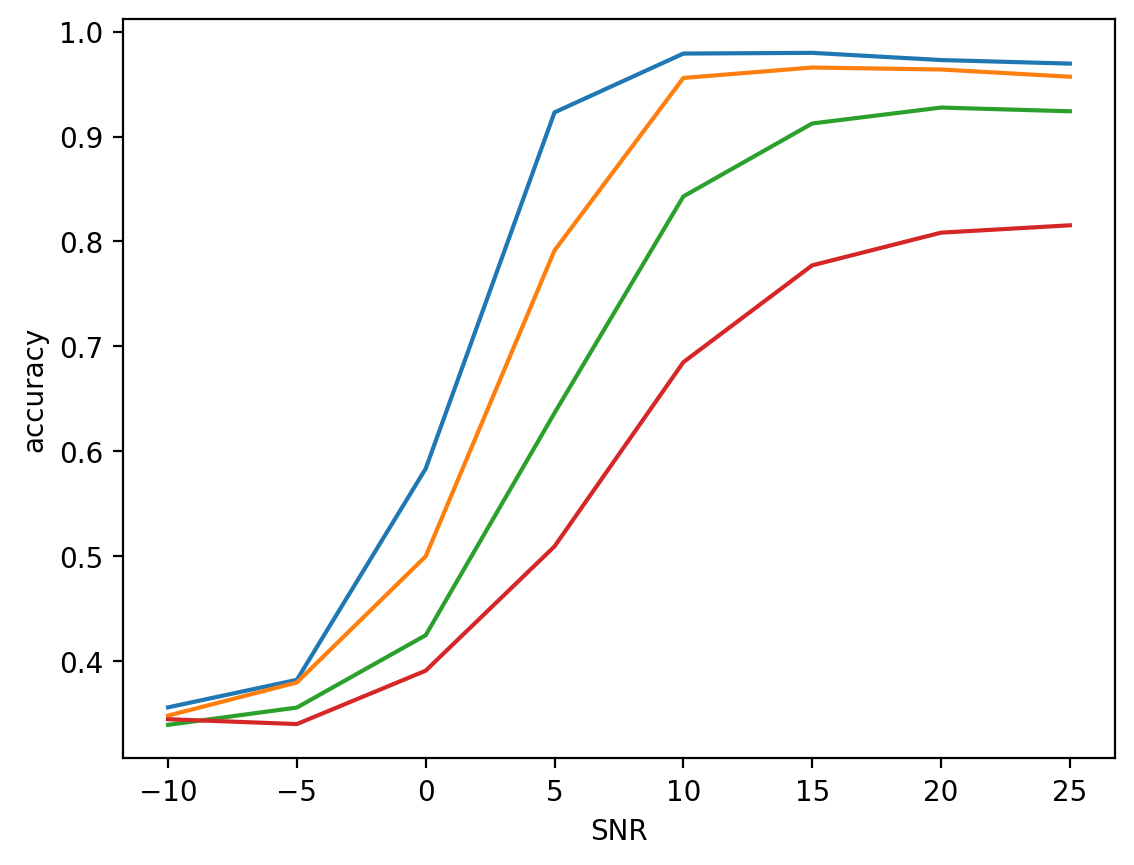

In [62]:
rnn_model.eval()
test_rnn(rnn_model, test_loader, 32)
test_rnn(rnn_model, test_loader, 16)
test_rnn(rnn_model, test_loader, 8)
test_rnn(rnn_model, test_loader, 4)

#### FCN

In [68]:
class RegFCNModel(nn.Module):
    def __init__(self):
        super(RegFCNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 4), padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 64, (1, 4), padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, (2, 4)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Conv2d(64, len(classes), kernel_size=1),
        )
        
    def forward(self, x):
        # add dimension for channel
        out = self.conv(x.unsqueeze(dim=1))
        out = self.fc(out)
        #out, _ = torch.max(out, -1)
        #out = torch.mean(out, -1)
        out = torch.squeeze(out)
        out = self.avg_pool(out)
        out = torch.squeeze(out)
        return out

In [69]:
for inputs, labels, _, _ in train_loader:
    print(inputs.shape, labels.shape)
    model = RegFCNModel()
    outputs = model(inputs)
    print(outputs.shape)
    break

torch.Size([64, 2, 32]) torch.Size([64])
torch.Size([64, 3])


In [70]:
fcn_model = RegFCNModel()
fcn_model.to(device)
fcn_criterion = nn.CrossEntropyLoss()
fcn_optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [71]:
train_fcn(fcn_model, train_loader, val_loader, fcn_criterion, fcn_optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.73754
   Val loss: 0.62656

EPOCH 1
 Train loss: 0.61141
   Val loss: 0.58816

EPOCH 2
 Train loss: 0.58856
   Val loss: 0.56960

EPOCH 3
 Train loss: 0.58136
   Val loss: 0.55960

EPOCH 4
 Train loss: 0.57774
   Val loss: 0.56308

EPOCH 5
 Train loss: 0.57027
   Val loss: 0.55983

EPOCH 6
 Train loss: 0.56984
   Val loss: 0.55590

EPOCH 7
 Train loss: 0.56575
   Val loss: 0.55615

EPOCH 8
 Train loss: 0.56662
   Val loss: 0.55537

EPOCH 9
 Train loss: 0.56219
   Val loss: 0.54323



Test accuracy: 77.115
{-10: 0.3519599666388657, -5: 0.36023294509151416, 0: 0.5525260625501203, 5: 0.9490229396771452, 10: 0.9932773109243698, 15: 0.9933333333333333, 20: 0.9926888708367181, 25: 0.9930675909878682}
Test accuracy: 74.406
{-10: 0.35279399499582986, -5: 0.3652246256239601, 0: 0.5132317562149158, 5: 0.8394222599830077, 10: 0.9647058823529412, 15: 0.9766666666666667, 20: 0.9821283509341998, 25: 0.9740034662045061}
Test accuracy: 66.938
{-10: 0.3586321934945788, -5: 0.35524126455906824, 0: 0.458700882117081, 5: 0.6694987255734919, 10: 0.8453781512605042, 15: 0.885, 20: 0.8984565393988627, 25: 0.8968804159445407}


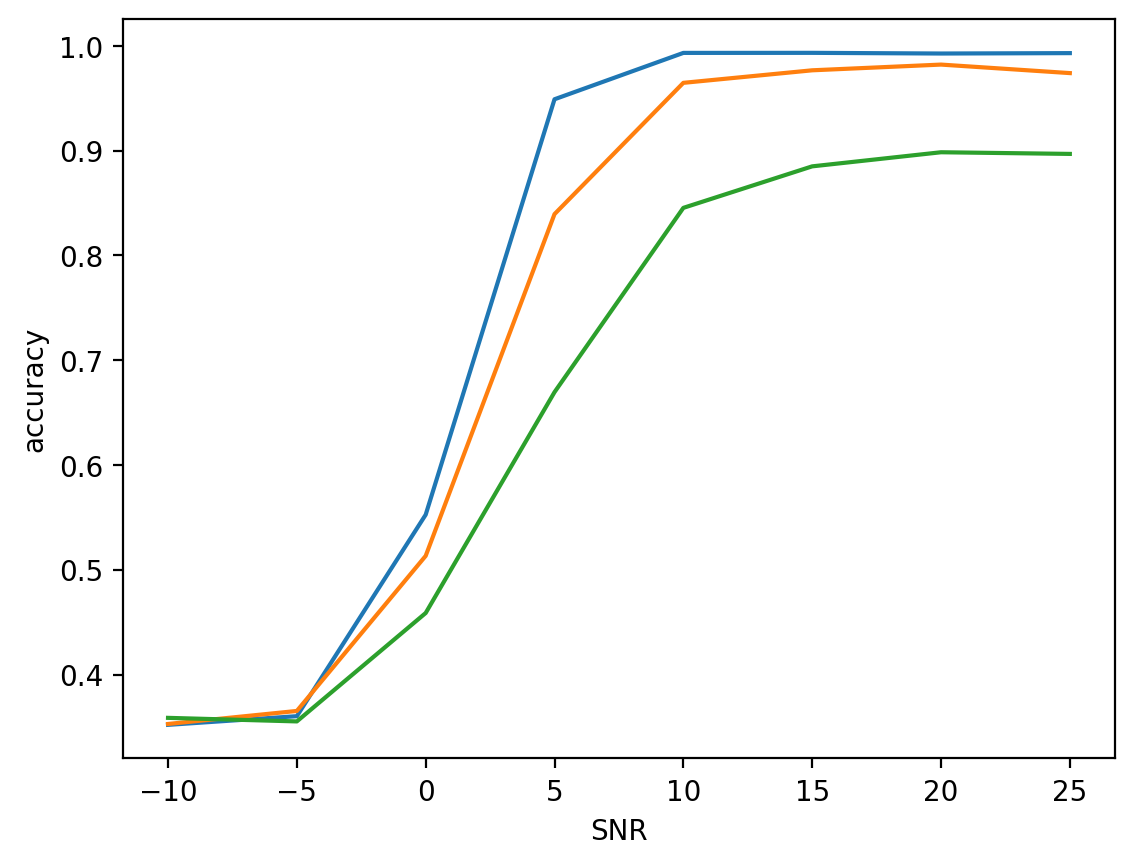

In [72]:
fcn_model.eval()
test_fcn(fcn_model, test_loader, 32)
test_fcn(fcn_model, test_loader, 16)
test_fcn(fcn_model, test_loader, 8)

In [385]:
train_fcn(fcn_model, train_loader, val_loader, fcn_criterion, fcn_optimizer, nepoch=10, random_seq_lens=8)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.56697
   Val loss: 0.52702

EPOCH 1
 Train loss: 0.55624
   Val loss: 0.52668

EPOCH 2
 Train loss: 0.55808
   Val loss: 0.52669

EPOCH 3
 Train loss: 0.55120
   Val loss: 0.52323

EPOCH 4
 Train loss: 0.55103
   Val loss: 0.52525

EPOCH 5
 Train loss: 0.55214
   Val loss: 0.52507

EPOCH 6
 Train loss: 0.54761
   Val loss: 0.52383

EPOCH 7
 Train loss: 0.54390
   Val loss: 0.52399

EPOCH 8
 Train loss: 0.54957
   Val loss: 0.52352

EPOCH 9
 Train loss: 0.54470
   Val loss: 0.52148



Test accuracy: 77.927
{-10: 0.3580858085808581, -5: 0.3882752761257434, 0: 0.6269515201314708, 5: 0.9385665529010239, 10: 0.9804919423240034, 15: 0.9785655399835119, 20: 0.980688497061293, 25: 0.9814366424535916}
Test accuracy: 74.698
{-10: 0.3564356435643564, -5: 0.3772302463891249, 0: 0.5324568611339359, 5: 0.8447098976109215, 10: 0.9609838846480068, 15: 0.9629018961253092, 20: 0.9697732997481109, 25: 0.9693301049233253}
Test accuracy: 68.625
{-10: 0.34405940594059403, -5: 0.36278674596431604, 0: 0.45357436318816763, 5: 0.7073378839590444, 10: 0.8719253604749788, 15: 0.9051937345424568, 20: 0.9269521410579346, 25: 0.9144471347861178}


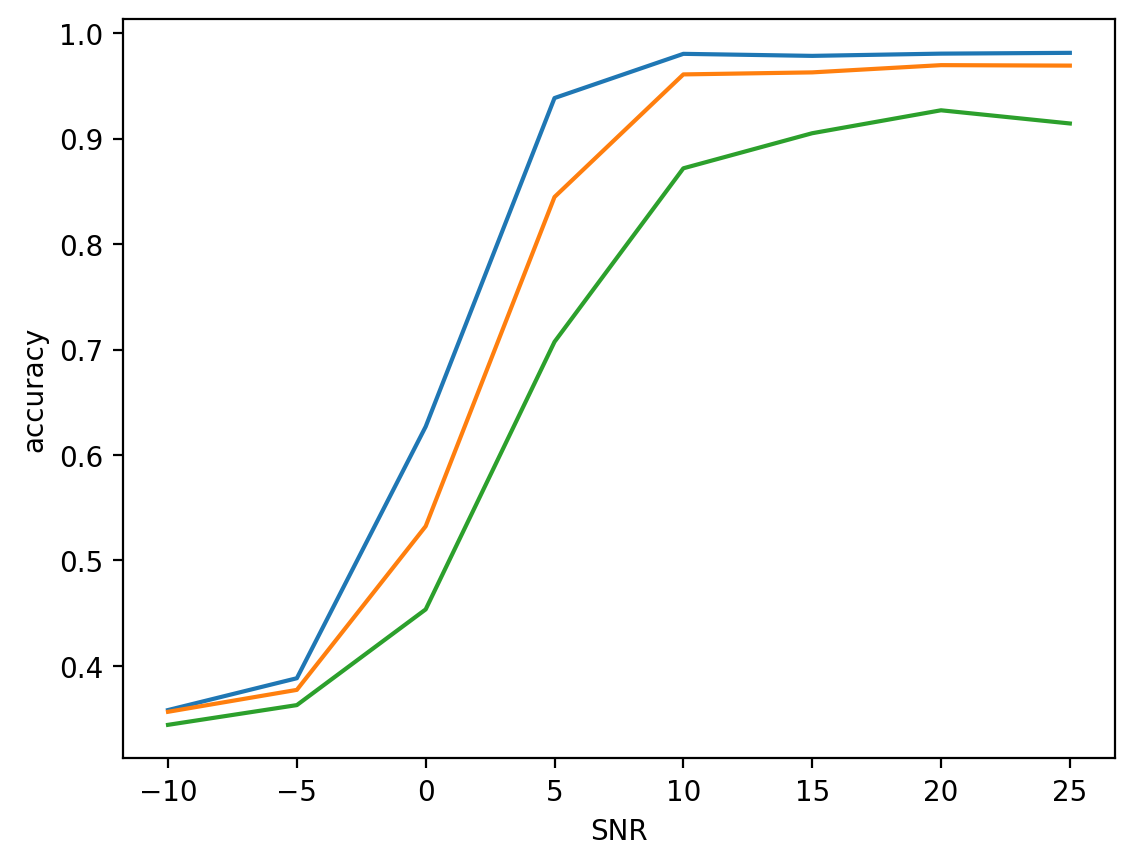

In [386]:
fcn_model.eval()
test_fcn(fcn_model, test_loader, 32)
test_fcn(fcn_model, test_loader, 16)
test_fcn(fcn_model, test_loader, 8)

#### GRU-FCN

In [276]:
class RegRNN_FCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, conv_out_size, bidirectional=True):
        super(RegRNN_FCNModel, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.rnn_dropout = nn.Dropout(0.8)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 128, (1, 5), padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (1, 3), padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, (2, 3)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128)
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fcn = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1) + conv_out_size, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, len(classes))
        )
        
    def forward(self, x, h):
        # rnn
        rnn_out, hn = self.rnn(x.permute(0, 2, 1), h)
        last_rnn_out = rnn_out[:, -1]
        last_rnn_out = self.rnn_dropout(last_rnn_out)
        # fcn
        cnn_out = self.cnn(x.unsqueeze(dim=1))
        cnn_out = torch.squeeze(cnn_out)
        cnn_out = self.avg_pool(cnn_out)
        cnn_out = torch.squeeze(cnn_out)
        # combine
        out = torch.concat([last_rnn_out, cnn_out], dim=1)
        out = self.fcn(out)
        return out, hn

In [277]:
hidden_size = 512
num_layers = 3
conv_out_size = 128
rnn_fcn_model = RegRNN_FCNModel(2, hidden_size, num_layers, conv_out_size, True)
rnn_fcn_model.to(device)
rnn_fcn_criterion = nn.CrossEntropyLoss()
rnn_fcn_optimizer = torch.optim.Adam(rnn_fcn_model.parameters(), lr=1e-4)

In [226]:
temp_rnn_fcn = rnn_fcn_model

In [278]:
train_rnn_fcn(rnn_fcn_model, train_loader, val_loader, rnn_fcn_criterion, rnn_fcn_optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.63668
   Val loss: 0.55937

EPOCH 1
 Train loss: 0.56418
   Val loss: 0.54955

EPOCH 2
 Train loss: 0.55804
   Val loss: 0.55237

EPOCH 3
 Train loss: 0.55459
   Val loss: 0.55002

EPOCH 4
 Train loss: 0.55277
   Val loss: 0.55210

EPOCH 5
 Train loss: 0.55053
   Val loss: 0.54950

EPOCH 6
 Train loss: 0.54885
   Val loss: 0.54305

EPOCH 7
 Train loss: 0.54539
   Val loss: 0.54103

EPOCH 8
 Train loss: 0.54428
   Val loss: 0.54134

EPOCH 9
 Train loss: 0.54448
   Val loss: 0.53198



Test accuracy: 75.385
{-10: 0.3424092409240924, -5: 0.3389974511469839, 0: 0.4428923582580115, 5: 0.9112627986348123, 10: 0.998303647158609, 15: 1.0, 20: 0.9991603694374476, 25: 0.9975786924939467}
Test accuracy: 73.729
{-10: 0.35066006600660066, -5: 0.35514018691588783, 0: 0.4675431388660641, 5: 0.8071672354948806, 10: 0.9754028837998303, 15: 0.9843363561417972, 20: 0.9874055415617129, 25: 0.9685230024213075}
Test accuracy: 67.635
{-10: 0.3341584158415842, -5: 0.36618521665250636, 0: 0.43303204601479045, 5: 0.6697952218430034, 10: 0.8702290076335878, 15: 0.9060181368507831, 20: 0.926112510495382, 25: 0.9015334947538337}


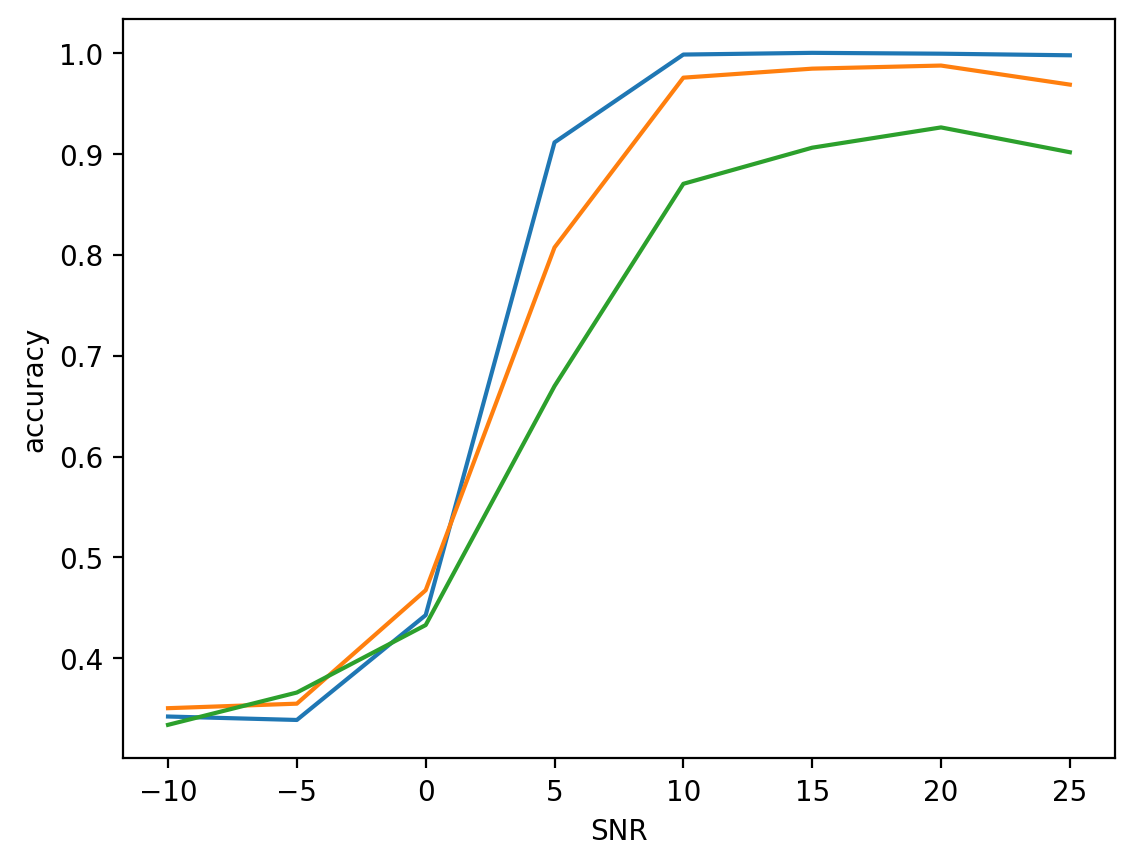

In [230]:
rnn_fcn_model.eval()
test_rnn_fcn(rnn_fcn_model, test_loader, 32)
test_rnn_fcn(rnn_fcn_model, test_loader, 16)
test_rnn_fcn(rnn_fcn_model, test_loader, 8)

Test accuracy: 76.406
{-10: 0.35973597359735976, -5: 0.37638062871707734, 0: 0.5645028759244043, 5: 0.8703071672354948, 10: 0.9762510602205259, 15: 0.9876339653751031, 20: 0.9865659109991604, 25: 0.9887005649717514}
Test accuracy: 75.458
{-10: 0.3438789191419142, -5: 0.3570252761257434, 0: 0.5095521774856204, 5: 0.8580151450511946, 10: 0.990219465648855, 15: 0.9943322341302555, 20: 0.9911314021830394, 25: 0.9904913236481033}
Test accuracy: 75.562
{-10: 0.3457095709570957, -5: 0.3619371282922685, 0: 0.5102711585866886, 5: 0.8660409556313993, 10: 0.9821882951653944, 15: 0.9909315746084089, 20: 0.9924433249370277, 25: 0.993543179983858}
Test accuracy: 76.094
{-10: 0.3424092409240924, -5: 0.34324553950722175, 0: 0.48315529991783074, 5: 0.9257679180887372, 10: 0.998303647158609, 15: 1.0, 20: 0.998320738874895, 25: 0.9959644874899112}


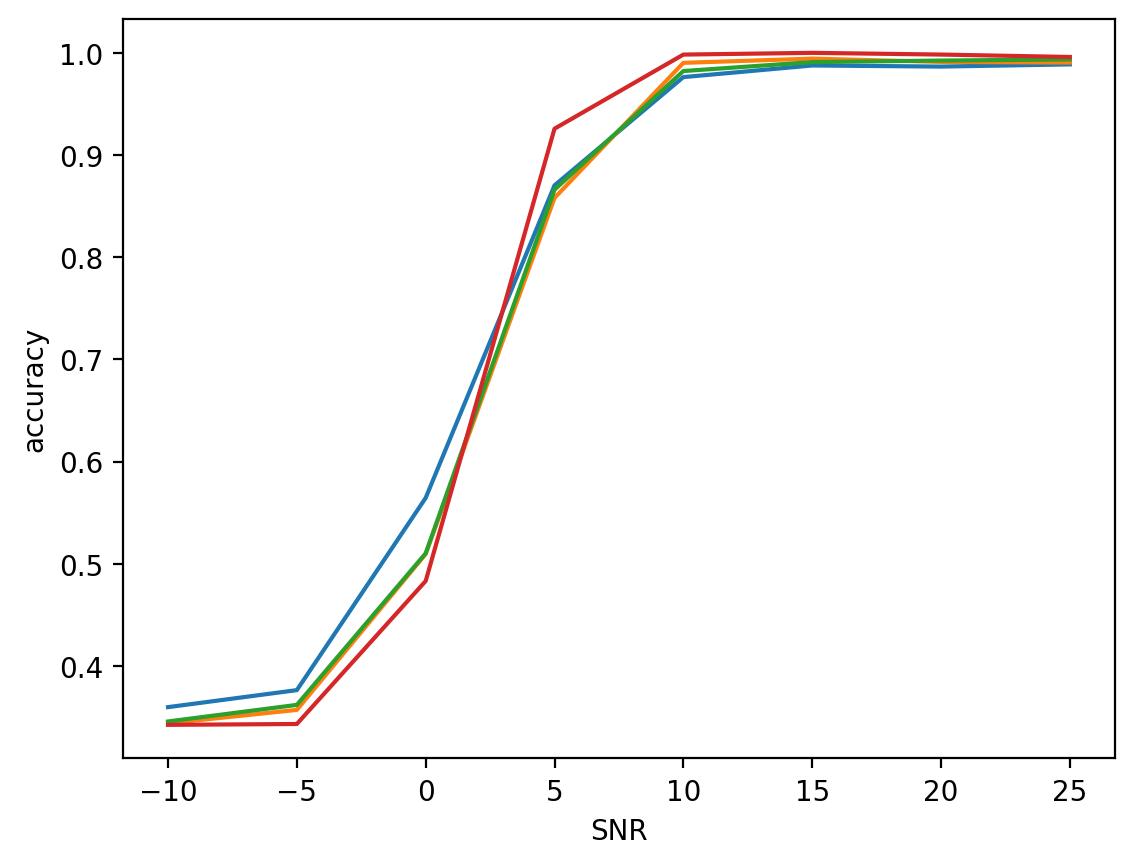

In [180]:
cnn_model.eval()
test_cnn(cnn_model, test_loader)
rnn_model.eval()
test_rnn(rnn_model, test_loader, 32)
fcn_model.eval()
test_fcn(fcn_model, test_loader, 32)
rnn_fcn_model.eval()
test_rnn_fcn(rnn_fcn_model, test_loader, 32)